datas loaded [debug = 0]
Reshaped Training set   (1000000, 784) (1000000, 10)
    300001 |        1408 |       0.05000 |       10000 |       0.96 |     0.00100 |             0.50 |         
Initialized
Minibatch loss at step 0 : 9945.208 - acc: 9.7% | Validation acc: 21.5%
Minibatch loss at step 5000 : 315.654 - acc: 20.2% | Validation acc: 22.8%
Minibatch loss at step 10000 : 194.595 - acc: 34.8% | Validation acc: 40.2%
Minibatch loss at step 15000 : 121.136 - acc: 54.9% | Validation acc: 65.3%
Minibatch loss at step 20000 : 76.268 - acc: 63.6% | Validation acc: 75.3%
Minibatch loss at step 25000 : 48.538 - acc: 71.5% | Validation acc: 79.4%
Minibatch loss at step 30000 : 31.236 - acc: 74.6% | Validation acc: 81.6%
Minibatch loss at step 35000 : 20.402 - acc: 77.7% | Validation acc: 82.8%
Minibatch loss at step 40000 : 13.474 - acc: 79.5% | Validation acc: 83.5%
Minibatch loss at step 45000 : 8.991 - acc: 82.5% | Validation acc: 84.2%
Minibatch loss at step 50000 : 6.186 - acc: 81.3% 

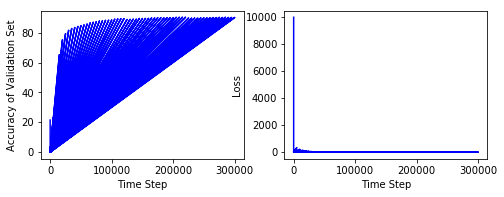

In [14]:
"""
Deep Learning
Assignment 3 - problem 4
Previously in 2_fullyconnected.ipynb, you trained a logistic regression and a neural network model.
The goal of this assignment is to explore regularization techniques.
"""

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
import datetime
from six.moves import cPickle as pickle
from scipy.ndimage import convolve

"""
Run SGD with a hidden layer and regularization.
> num_steps:
     Number of steps to run SGD minibatch training. In each step a new minibatch is fed through the network.
> learning_rate:
     SGD learning rate, passed direction to GradientDescentOptimizer.
> l2_reg_beta:
     The loss is regularized with L2 loss on all weights. This is the regularization coefficient. 
     Setting it to 0 means no L2 loss regularization. Otherwise, small values work well.
> dropout_keep_prob:
     Dropout "keep" probability for outputs of the hidden layer. Set to 1 to avoid dropout altogether.
"""

def reformat(dataset, labels):
    #Reformat into a shape that's more adapted to the models we're going to train:
    #data as a flat matrix, labels as float 1-hot encodings.
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(n_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

def hiddenLayersModel (x, w, b, keep_prob):
    #Dropout "keep" probability for outputs of the hidden layer.
    #Set to 1 to avoid dropout altogether, ie for validation and test pred  

    # Hidden layer #1 with RELU activation + dropout
    hiddenLayer1 = tf.add(tf.matmul(x, w['h1']), b['b1'])
    hiddenLayer1 = tf.nn.relu(hiddenLayer1)
    hiddenLayer1 = tf.nn.dropout(hiddenLayer1,keep_prob=keep_prob)
    # Hidden layer #2 with RELU activation + dropout
    hiddenLayer2 = tf.add(tf.matmul(hiddenLayer1, w['h2']), b['b2'])
    hiddenLayer2 = tf.nn.relu(hiddenLayer2)
    hiddenLayer2 = tf.nn.dropout(hiddenLayer2,keep_prob=keep_prob)
    # Output layer with linear activation
    outputLayer = tf.add(tf.matmul(hiddenLayer2, w['out']), b['out'])
    return outputLayer

def run_SGD_hiddenLayers_Reg_Dropout(graph, num_steps=3001, learning_rate=0.1, 
                                     l2_reg_beta=0.0, dropout_keep_prob=1, 
                                     decay_steps=1000, decay_rate=0.96):

    print('    %d |        %d |       %0.5f |       %d |       %0.2f |     %0.5f |             %0.2f |         '
         % (num_steps, batch_size, learning_rate, decay_steps, decay_rate, l2_reg_beta, dropout_keep_prob))

    with graph.as_default():
                       
        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a training minibatch.
        tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, n_input))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, n_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
  
        # Variables : layers weight & bias
        weights = {
            'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1])),
            'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2])),
            'out': tf.Variable(tf.truncated_normal([n_hidden_2, n_labels]))
        }
        
        biases = {
            'b1': tf.Variable(tf.zeros([n_hidden_1])),
            'b2': tf.Variable(tf.zeros([n_hidden_2])),
            'out': tf.Variable(tf.zeros([n_labels]))
        }
 
        saver = tf.train.Saver()

        # Construct model
        pred = hiddenLayersModel(tf_train_dataset, weights, biases, dropout_keep_prob)

        # Loss (Cost)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=tf_train_labels))
        reg_loss = tf.reduce_mean(loss + l2_reg_beta * (tf.nn.l2_loss(weights['h1']) 
                                                        + tf.nn.l2_loss(weights['h2'])
                                                        + tf.nn.l2_loss(weights['out'])
                                                       )
                                 )

        # Optimizer.
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(reg_loss)
        global_step = tf.Variable(0)  # count the number of steps taken.
        learning_rate = tf.train.exponential_decay(learning_rate=learning_rate, global_step=global_step,
                                                   decay_steps=decay_steps,decay_rate=decay_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(reg_loss, global_step=global_step)

  
        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(pred)
        valid_prediction = tf.nn.softmax(hiddenLayersModel(tf_valid_dataset, weights, biases, 1)) #no dropout
        test_prediction = tf.nn.softmax(hiddenLayersModel(tf_test_dataset, weights, biases, 1)) #no dropout
        
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print ('Initialized')
        summary_data = np.zeros((num_steps, 3))

        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run([optimizer, reg_loss, train_prediction], feed_dict=feed_dict)

            if (step % 5000 == 0):
                valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
                if step == 0:
                    index = 0
                else:
                    index = int(step / 1000)
                summary_data[index] = [step, valid_accuracy, l]
                print ("Minibatch loss at step %d : %.3f - acc: %.1f%% | Validation acc: %.1f%%" 
                       % (step, l, accuracy(predictions, batch_labels),valid_accuracy))
    
        acc = accuracy(test_prediction.eval(), test_labels)
        print ("Test accuracy: %.1f%%" % acc)
        #print('    %d |        %d |       %0.5f |       %d |       %0.2f |     %0.5f |             %0.2f |         %.1f%%'
        #      % (num_steps, batch_size, learning_rate, decay_steps, decay_rate, l2_reg_beta, dropout_keep_prob, acc))

        save_path = saver.save(session, "./model.%s.ckpt" % '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now()))
        print("Model saved in file: %s" % save_path)
        return summary_data

def plotting(data):
    import matplotlib.pyplot as plt
    %matplotlib inline
    fig = plt.figure(figsize=(8, 6))

    ax1 = fig.add_subplot(221)
    ax1.plot(data[:,0], data[:,1], 'b-')
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Accuracy of Validation Set")
    ax2 = fig.add_subplot(222)
    ax2.plot(data[:,0], data[:,2], 'b-')
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Loss")
        
def nudge_dataset(X,Y):

    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((28, 28)), mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y
    
     
        
if __name__ == '__main__':
    debug = 0
    nudging_training_dataset = 1

    #parameters
    pickle_file = 'notMNIST.pickle'
    image_size = 28
    batch_size = 1408
    n_hidden_1 = 1024 # 1st layer number of features
    n_hidden_2 = 512 # 2st layer number of features
    n_input = image_size * image_size # data input (img shape: 28*28)
    n_labels = 10 #(0-9)
    
    #First reload the data we generated in 1_notmnist.ipynb
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        train_dataset = save['train_dataset']
        train_labels = save['train_labels']
        valid_dataset = save['valid_dataset']
        valid_labels = save['valid_labels']
        test_dataset = save['test_dataset']
        test_labels = save['test_labels']
        del save  # hint to help gc free up memory
        print('datas loaded [debug = %d]' % debug)
        train_dataset_o, train_labels_o = reformat(train_dataset, train_labels)
        valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
        test_dataset, test_labels = reformat(test_dataset, test_labels)
        
        if nudging_training_dataset == 1:
            # nudge to get 5X training set
            train_dataset, train_labels = nudge_dataset(train_dataset_o, train_labels_o)
            # nudge Xn and Yn from last step to get 25X training set
            #train_dataset, train_labels = nudge_dataset(Xn, Yn)
        else:
            train_dataset, train_labels = train_dataset_o, train_labels_o

        print('Reshaped Training set  ', train_dataset.shape, train_labels.shape)
        
        if debug == 1:
            print('Reshaped Validation set', valid_dataset.shape, valid_labels.shape)
            print('Reshaped Test set      ', test_dataset.shape, test_labels.shape)
            num_steps=5
        else:
            num_steps=300001            
    
    graph = tf.Graph()
    summary_data = run_SGD_hiddenLayers_Reg_Dropout(graph,
                                                    num_steps,
                                                    learning_rate=0.05,
                                                    l2_reg_beta=0.001,
                                                    dropout_keep_prob=0.5,
                                                    decay_steps=10000,
                                                    decay_rate=0.96
                                                   )
    plotting(summary_data)



#enlarge dataset

In [ ]:
"""
running SGD: 2 hidden layers : 1024 nodes / 512 nodes
num steps | batch size | learning rate | decay steps | decay rate | l2 reg beta |dropout keep prob | test accuracy
    40001 |        512 |       0.05000 |       10000 |       0.90 |     0.00100 |             0.50 |         89.5%
    40001 |        256 |       0.05000 |       10000 |       0.90 |     0.00100 |             0.50 |         89.3%
    60001 |        128 |       0.05000 |       10000 |       0.90 |     0.00100 |             0.50 |         90.8%
    60001 |        256 |       0.05000 |       10000 |       0.90 |     0.00100 |             0.50 |         91.6%
    60001 |        512 |       0.05000 |       10000 |       0.90 |     0.00100 |             0.50 |         91.8%
    60001 |       1024 |       0.05000 |       10000 |       0.90 |     0.00100 |             0.50 |         91.7%
    60001 |       1152 |       0.05000 |       10000 |       0.90 |     0.00100 |             0.50 |         91.6%
    60001 |       1152 |       0.05000 |       10000 |       0.96 |     0.00100 |             1.00 |         94.6%    
    60001 |       1280 |       0.05000 |       10000 |       0.96 |     0.00100 |             1.00 |         95.0% 
    60001 |       1408 |       0.05000 |       10000 |       0.96 |     0.00100 |             1.00 |         95.3%***
    60001 |       1536 |       0.05000 |       10000 |       0.96 |     0.00100 |             1.00 |         95.1%
    60001 |       1408 |       0.05000 |        5000 |       0.99 |     0.00100 |             1.00 |         95.1%
    60001 |       1408 |       0.05000 |        5000 |       0.98 |     0.00100 |             1.00 |         95.1%
    60001 |       1408 |       0.05000 |       10000 |       0.96 |     0.00100 |             0.90 |         94.8%
    60001 |       1408 |       0.05000 |       10000 |       0.96 |     0.00100 |             0.50 |         93.0%
Reshaped Training set   (1000000, 784) (1000000, 10)
    60001 |       1408 |       0.05000 |       10000 |       0.96 |     0.00100 |             0.50 |         92.4%
   300001 |       1408 |       0.05000 |       10000 |       0.96 |     0.00100 |             0.50 |         95.7%
   maximum reached on validation set betweem 210'000 and 220'000' steps (90.4%)
"""